# Simple CNN for compare default parameters in further applications
#### Previous adversial ensemble network will be created in another file

In [1]:
#import os
#import random
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #If using Matplotlib on Windows with different versions, this will surpress error
#import pandas as pd
import torch
#import torchvision
#import torchvision.transforms as transforms
#import torch.nn as nn
#
#import statistics 
#from scipy import ndimage #Image Smoothing
#from collections import Counter
import foolbox as fb
#from torch.autograd import Variable
#device = torch.device("cpu")
import sys
sys.path.append('../functions')
sys.path.append('../Models')
from clean_nn_weights import reset_weights
from img_bit_reduction import bit_reduction
from img_median_smoothing import median_smoothing
from dataloader_ens import dataloader_ens
from generate_adversarial_samples_ens import generate_pertubated_examples
from calculate_threshold_t import calculate_threshold_t
from evaluate_adversarial_detection import evaluate_adversarial_detection
from evaluate_accuracy_image_rectification_ensemble import evaluate_attack
from train_ensemble import train
from test_ensemble import test

import ensemble_cnn
#Git merge main/main master

Define dataloader parameter

In [2]:
random_seed = 1337
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.manual_seed(random_seed)  #Static random seed for reproducibility
device = torch.device("cpu")
dataset_name = "MNIST"
train_loader,test_loader = dataloader_ens(dataset_name)

Loaded MNIST dataloader


In [3]:
if (str(dataset_name) == "MNIST"):
    network = ensemble_cnn.ensemble_rectification(1,10)
    network.apply(reset_weights)
else:
    network = ensemble_cnn.ensemble_rectification(3,10)
    network.apply(reset_weights)


Reset trainable parameters of layer = Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=800, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(30, 75, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=1200, out_features=900, bias=True)
Reset trainable parameters of layer = Linear(in_features=900, out_features=10, bias=True)
Reset trainable parameters of layer = Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(50, 125, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=2000, out_features=1000, bias=True)
Reset trainable pa

In [4]:
import torch.optim as optim
log_interval = 187 #60000/batch_size_train = 1875 => 10 Datapoints per Epoch => 187 Logs per Epoch
n_epochs = 10
learning_rate = 0.007 #0.007
momentum = 0.5
load_data = 1
load_adv = 1
###########
use_upgraded_net = 1
use_ensemble = 1
use_integrated_ensemble = 1
##########
save_net = 0
##########

#device = "cuda:0"
#network.to(device)
if (use_ensemble == 0):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if (use_ensemble and use_integrated_ensemble):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

if (load_data and use_upgraded_net == 1):
    if (use_ensemble and use_integrated_ensemble):

        if  "CIFAR" in str(test_loader.dataset):
            if (load_adv):
                network.load_state_dict(torch.load('../../src/results/model_integrated_ens_adv_cifar.pth'))
                print('Loaded integrated adversarial trained ensemble model for cifar from file')
                optimizer.load_state_dict(torch.load('../../src/results/optimizer_integrated_adv_cifar.pth'))
                print('Loaded adversarial trained optimizer from integrated ensemble model for cifar')
            else:
                network.load_state_dict(torch.load('../../src/results/model_integrated_ens_cifar.pth'))
                print('Loaded integrated ensemble model for cifar from file')
                optimizer.load_state_dict(torch.load('../../src/results/optimizer_integrated_cifar.pth'))
                print('Loaded optimizer from integrated ensemble model for cifar')
        else:
            if (load_adv):
                network.load_state_dict(torch.load('../../src/results/model_integrated_ens_adv.pth')) #../src/results/model_integrated_ens_adv_mnist_03.pth
                print('Loaded integrated mnist ensemble model from file')
                optimizer.load_state_dict(torch.load('../../src/results/optimizer_integrated_adv.pth')) # ../src/results/optimizer_integrated_adv_mnist_03.pth
                print('Loaded optimizer mnist from integrated ensemble model')
            else:
                network.load_state_dict(torch.load('../../src/results/model_integrated_ens.pth'))
                print('Loaded integrated ensemble model from file')
                optimizer.load_state_dict(torch.load('../../src/results/optimizer_integrated.pth'))
                print('Loaded optimizer from integrated ensemble model')

    if (use_ensemble==0 and use_integrated_ensemble==0):
        network.load_state_dict(torch.load('../../src/results/model_upgraded_ens.pth'))
        print('Loaded upgraded model from file')
        optimizer.load_state_dict(torch.load('../../src/results/optimizer_upgraded.pth'))
        print('Loaded optimizer from upgraded model')

if (save_net==1):
    print('WARNING: Saving model to file!! Will overwrite existing file!!!')

Loaded integrated mnist ensemble model from file
Loaded optimizer mnist from integrated ensemble model


In [13]:
train(network,optimizer,train_loader,dataset_name,2)

Using normal train
Train for 2 epochs


KeyboardInterrupt: 

In [5]:
base_accuracy=test(network,test_loader)


Test set: Avg. loss: 0.0006, Accuracy: 9924/10000 (99%)



In [6]:
evaluate_attack(test_loader,network,dataset_name,base_accuracy,device,is_attack=True,attack=fb.attacks.FGSM(),epsilon=[1],t=0,median_kernel=3)

Attack Mode!

Test set: Avg. loss baseline: 0.0567, Accuracy: 62.650001525878906/10000 (63%), Accuracy_Median_Smooth: 61.33000183105469, Accuracy_Bit_Reduction: 91.1500015258789, Accuracy_Jury_Ensemble: 68.06, Accuracy_Pooled_Ensemble: 81.16999816894531, Threshold t Baseline: 0, False Positives Baseline: 0, True Negatives Baseline: 0, Pertubated Samples Detected: 3719, Pertubated Samples Real: 3719

Attack Success (Pooled): 0.3634233772754669

Detection Accuracy 100.0%
L0 Distance: 13.81809332431891
L2 Distance: 0.6160246015359194
Linf Distance: 2.756989042728375


In [9]:
ad_data,ad_label,original_data,original_label = generate_pertubated_examples(network,test_loader,fb.attacks.FGSM(),dataset_name,n=100,epsilon=[0.5])

Run attack: LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
Run attack with epsilon: [0.5]
Generating 100 samples for legitimate and adversarial
Adversarial samples:  100
Legitimate samples:  100


In [7]:
import numpy as np

In [8]:
cut = int(min(len(ad_data),len(original_data))/2)
print("Train/Test split after {} samples".format(cut))
data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

if (len(ad_data)<=len(original_data)):
    data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
else:
    data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)

Train/Test split after 50 samples


In [9]:
import torch.nn.functional as F
import numpy as np
differences,adversarial_map=evaluation_paper(data_train,label_train,network,str(dataset_name))

Calculated train dataset distances


0.9990363121032715
2.9802322387695312e-06
0.6999125602841377
##########
0.0002085566520690918
1.822950890983958e-17
4.375830980613379e-06
Distance t legitimate mean: 4.375830980613379e-06
Distance t min-max: 0.00010576844215393066
Distance t conservative mean: 5.507213656727202e-05
Score legitimate mean: 94
Score min-max: 96
Score conservative mean: 96
##########
Max Score: 96
Min Score: 94
Mean Score: 95.33333333333333
##########
Evaluated peak distance calculation as best threshold for t
Evaluated adaptive calculation as best threshold for t
True T Distance:  96
True T Adaptive:  96
True T Legitimate Mean:  94


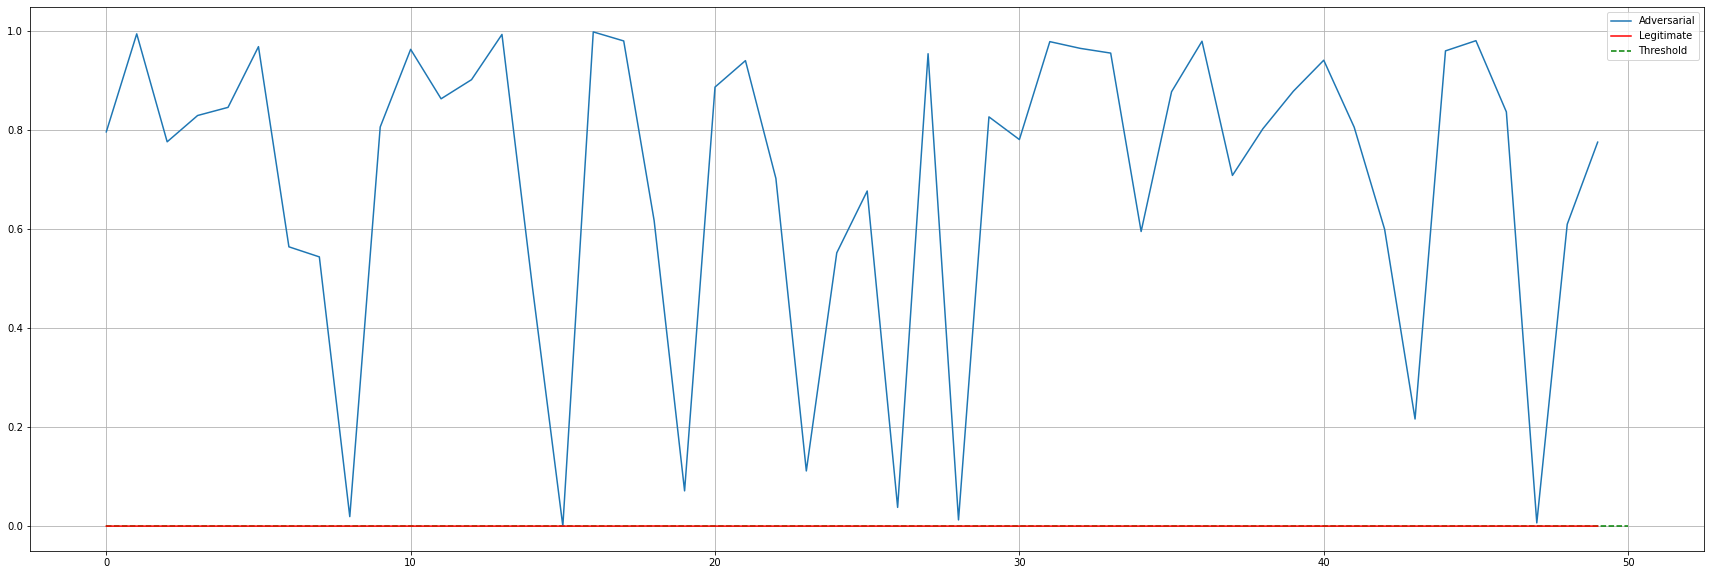

5.507213656727202e-05
Legitimate Samples  50
Adversarial Samples  50
True Negatives  49
False Positives  1
True Positives  49
False Negatives 1
##########
Detection Ratio TP:  98.0
Detection Ratio FN:  2.0
Detection Ratio TN:  98.0
Detection Ratio FP:  2.0


In [10]:
t_value=calculate_threshold_t(differences,adversarial_map,correction_t=1.0,print_output=True)

Train/Test split after 50 samples
Calculated train dataset distances
0.9990363121032715
2.9802322387695312e-06
0.6999125602841377
##########
0.0002085566520690918
1.822950890983958e-17
4.375830980613379e-06
Distance t legitimate mean: 4.375830980613379e-06
Distance t min-max: 0.00010576844215393066
Distance t conservative mean: 5.507213656727202e-05
Score legitimate mean: 94
Score min-max: 96
Score conservative mean: 96
##########
Max Score: 96
Min Score: 94
Mean Score: 95.33333333333333
##########
Evaluated peak distance calculation as best threshold for t
Evaluated adaptive calculation as best threshold for t
True T Distance:  96
True T Adaptive:  96
True T Legitimate Mean:  94


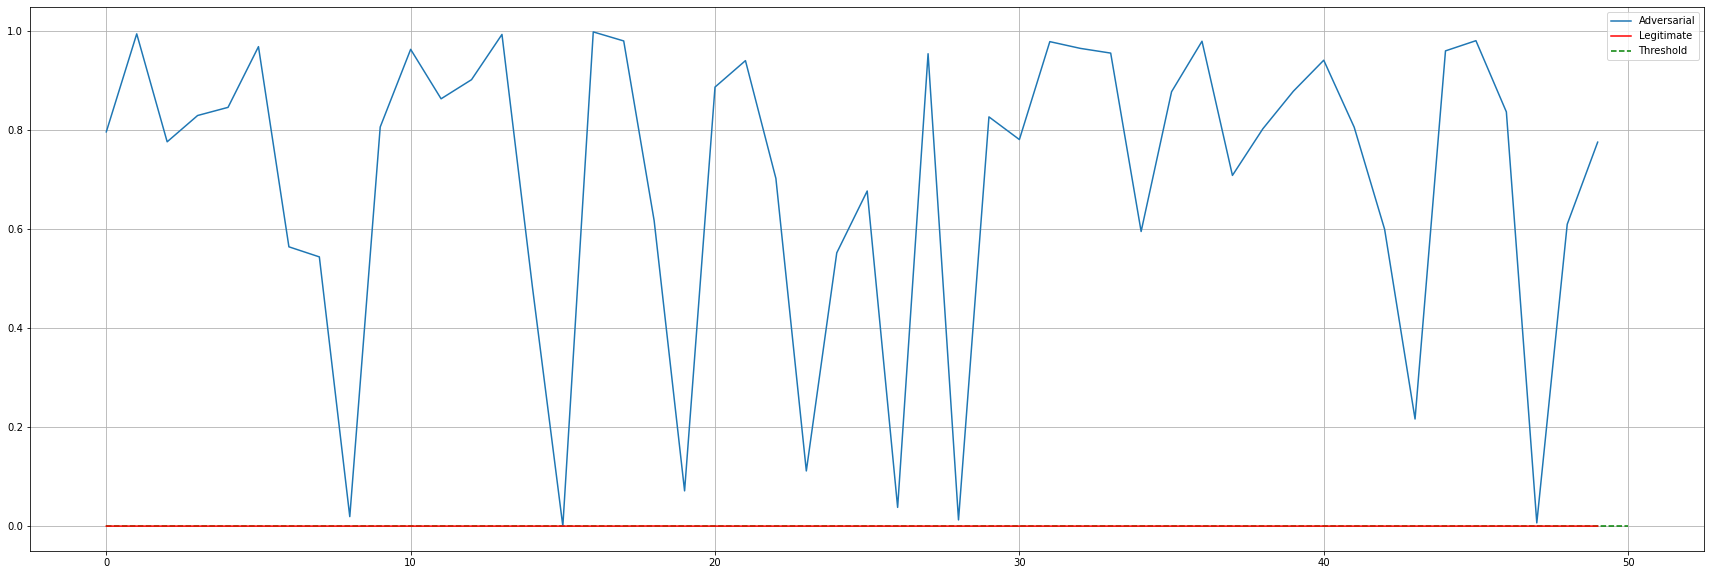

5.507213656727202e-05
Legitimate Samples  50
Adversarial Samples  50
True Negatives  49
False Positives  1
True Positives  49
False Negatives 1
##########
Detection Ratio TP:  98.0
Detection Ratio FN:  2.0
Detection Ratio TN:  98.0
Detection Ratio FP:  2.0
True Positives: 50
False Positives: 2
True Negatives: 48
False Negatives: 0
Accuracy: 0.98


In [11]:
cut = int(min(len(ad_data),len(original_data))/2)
print("Train/Test split after {} samples".format(cut))
data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

if (len(ad_data)<=len(original_data)):
    data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
else:
    data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)

differences,adversarial_map=evaluation_paper(data_train,label_train,network,str(dataset_name))
t_value=calculate_threshold_t(differences,adversarial_map,correction_t=1.0,print_output=True)
differences=evaluation_paper(data_test,label_test,network,str(dataset_name),t_value,evaluate=True)

In [18]:
def calculate_mnist (attack_method,epsilon):
    print("#######################")
    print("#######################")
    print("#######################")
    print(attack_method)
    ad_data,ad_label,original_data,original_label = generate_pertubated_examples(n=20,attack_method=attack_method,epsilon=epsilon,datatype="MNIST") #unten
    cut = int(min(len(ad_data),len(original_data))/2)
    print("Train/Test split after {} samples".format(cut))
    data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
    label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

    if (len(ad_data)<=len(original_data)):
        data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
        label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
    else:
        data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
        label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)
    differences,adversarial_map=evaluation_paper(data_train,label_train,network=network,datatype="MNIST")
    t_value=calculate_threshold_adversarial(differences,adversarial_map,correction_t=1.0,print_output=True)
    differences=evaluation_paper(data_test,label_test,network,t_value,evaluate=True,datatype="MNIST")
# CIFAR

In [14]:
#calculate_mnist(fb.attacks.FGSM(),[0.1])
#calculate_mnist(fb.attacks.FGSM(),[0.5])
#calculate_mnist(fb.attacks.FGSM(),[1])
#
#calculate_mnist(fb.attacks.FGM(),[0.1])
#calculate_mnist(fb.attacks.FGM(),[0.5])
#calculate_mnist(fb.attacks.FGM(),[1])
#
#calculate_mnist(fb.attacks.PGD(),[0.1])
#calculate_mnist(fb.attacks.PGD(),[0.5])
#calculate_mnist(fb.attacks.PGD(),[1])
#
#calculate_mnist(fb.attacks.L2PGD(),[0.1])
#calculate_mnist(fb.attacks.L2PGD(),[0.5])
#calculate_mnist(fb.attacks.L2PGD(),[1])
#
#calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[0.1])
#calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[0.5])
#calculate_mnist(fb.attacks.deepfool.L2DeepFoolAttack(),[1])
calculate_mnist(fb.attacks.carlini_wagner.L2CarliniWagnerAttack(),[0.1])
calculate_mnist(fb.attacks.carlini_wagner.L2CarliniWagnerAttack(),[0.5])
calculate_mnist(fb.attacks.carlini_wagner.L2CarliniWagnerAttack(),[1])

#######################
#######################
#######################
L2CarliniWagnerAttack(binary_search_steps=9, steps=10000, stepsize=0.01, confidence=0, initial_const=0.001, abort_early=True)
[0.1]


KeyboardInterrupt: 

##########################

In [116]:
ad_data,ad_label,original_data,original_label = generate_pertubated_examples(n=200,attack_method=fb.attacks.L2PGD(),epsilon=[1],datatype="MNIST") #unten

[1]
Not enough adversarial samples
torch.Size([1, 28, 28])


In [117]:
ad_data.shape

torch.Size([134, 1, 28, 28])

In [118]:
original_data.shape

torch.Size([200, 1, 28, 28])

### FOR CIFAR!

In [147]:
x = ad_data
y = original_data
train_data_adv = torch.empty(0,3,28,28)
train_data_orig = torch.empty(0,3,28,28)

for i in range(100):
    train_data_adv = torch.cat((train_data_adv,x[i].reshape(1,3,28,28)),dim=0)
for i in range(100):
    train_data_orig = torch.cat((train_data_orig,y[i].reshape(1,3,28,28)),dim=0)
#! This
train_data = torch.cat((train_data_adv,train_data_orig),dim=0)

########

x = ad_data
y = original_data
test_data_adv = torch.empty(0,3,28,28)
test_data_orig = torch.empty(0,3,28,28)
for i in range(100,200):
    test_data_adv = torch.cat((test_data_adv,x[i].reshape(1,3,28,28)),dim=0)
for i in range(100,200):
    test_data_orig = torch.cat((test_data_orig,y[i].reshape(1,3,28,28)),dim=0)
test_data = torch.cat((test_data_adv,test_data_orig),dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


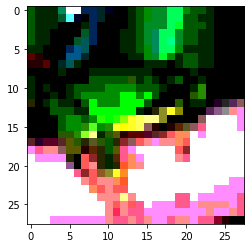

In [227]:
original_data[0].shape
plt.imshow(np.transpose(bit_reduction(train_data[66]), axes=[1, 2, 0]))

In [119]:
#data_com = torch.cat((ad_data,original_data),dim=1) #dim0 for mnist, dim1 for cifar
#label_com = torch.cat((ad_label,original_label),dim=0)

cut = int(min(len(ad_data),len(original_data))/2)
print("Train/Test split after {} samples".format(cut))
data_train = torch.cat((ad_data[0:cut],original_data[0:cut]),dim=0) #! MNIST, CIFAR deactivate line
label_train = torch.cat((ad_label[0:cut],ad_label[0:cut]),dim=0)

if (len(ad_data)<=len(original_data)):
    data_test = torch.cat((ad_data[cut:len(ad_data)],original_data[cut:len(ad_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(ad_data)],ad_label[cut:len(ad_data)]),dim=0)
else:
    data_test = torch.cat((ad_data[cut:len(original_data)],original_data[cut:len(original_data)]),dim=0) #! MNIST
    label_test = torch.cat((ad_label[cut:len(original_data)],ad_label[cut:len(original_data)]),dim=0)
# CIFAR
#print(data_train.shape)
#data_train=data_train.reshape(100,3,28,28)
#print(data_train.shape)

Train/Test split after 67 samples


In [16]:
len(data_test)

98

In [17]:
def evaluation_paper (dataset,labelset,network,t=0.01,evaluate=False,datatype="MNIST"):
        differences = []
        is_attack = True
        pertubated_detected = 0
        false_positive = 0
        false_negative = 0
        true_positive = 0
        true_negative = 0
        #if (datatype=="CIFAR"):
                #dataset=dataset.reshape(100,3,28,28)
        for i, (data,target) in enumerate(zip(dataset,labelset),0):
                if (datatype=="MNIST"):
                        data = data.unsqueeze(dim=1)
                if (datatype=="CIFAR"):
                        print(data.shape)
                        data = data.reshape(1,3,28,28)
                with torch.no_grad():
                        output = network(data)
                        # Output median smoothed ensemble
                        median_smoothed_batch=torch.clone(data)
                        median_smoothed_batch = median_smoothing(median_smoothed_batch,kernel_size=2)
                        output_ms = network(median_smoothed_batch)
                        # Output bit reduced ensemble
                        bit_reduced_batch=torch.clone(data)
                        bit_reduced_batch = bit_reduction(bit_reduced_batch, bit=1)
                        output_br = network(bit_reduced_batch)
                        # Test accuracy
                        pred = output.data.max(1, keepdim=True)[1]
                        pred_ms = output_ms.data.max(1, keepdim=True)[1]
                        pred_br = output_br.data.max(1, keepdim=True)[1]

                        output_ens = (output + output_ms + output_br)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax
                        pred_ens = output_ens.data.max(1, keepdim=True)[1]

                        softmax_baseline= F.softmax(output, dim=1)
                        softmax_median_smooth = F.softmax(output_ms, dim=1)
                        softmax_bitreduction = F.softmax(output_br, dim=1)
                        #!
                        #!
                        #if (i==49):
                        #        plt.imshow(np.transpose(data.reshape(3,28,28), axes=[1, 2, 0]))
                        #        plt.show()
                        #if (i==50):
                        #        plt.imshow(np.transpose(data.reshape(3,28,28), axes=[1, 2, 0]))
                        #        plt.show()
                        #!
                        # Jury Vote for ensemble predictions
                        for x in range(len(pred)):

                        # Calculate distance between baseline and rectificated softmax outputs
                                difference_ms=abs((softmax_baseline[x])-(softmax_median_smooth[x]))
                                difference_br=abs((softmax_baseline[x])-(softmax_bitreduction[x]))

                                distance_list=[max(difference_br).item(),max(difference_ms).item()]
                                #difference_total = statistics.fmean(distance_list)
                                difference_total = max(distance_list)
                                #print(difference_total)
                                #print(i)
                                #print("Max Tensor Distance:", difference_total)
                                differences.append(difference_total)
                                if (evaluate):
                                        if ((difference_total > t) and (i<=(len(dataset)/2)-1)):
                                                true_positive += 1
                                        if ((difference_total > t) and (i>(len(dataset)/2)-1)):
                                                false_positive += 1
                                        if ((difference_total < t) and (i<=(len(dataset)/2)-1)):
                                                false_negative += 1
                                        if ((difference_total < t) and (i>(len(dataset)/2)-1)):
                                                true_negative += 1
        if (evaluate):                        
                print("True Positives:",true_positive)
                print("False Positives:",false_positive)
                print("True Negatives:",true_negative)
                print("False Negatives:",false_negative)

                print("Accuracy:",(true_positive+true_negative)/(true_positive+true_negative+false_negative+false_positive))
        else:
                print("Calculated train dataset distances")
        a = [0]*int((len(dataset)/2))
        b = [1]*int((len(dataset)/2))
        c = b + a
        return(differences,c)

In [120]:
differences,adversarial_map=evaluation_paper(data_train,label_train,network=network,datatype="MNIST")
#data_train = MNIST
#train_data = CIFAR!

Calculated train dataset distances


Text(0, 0.5, 'Distance')

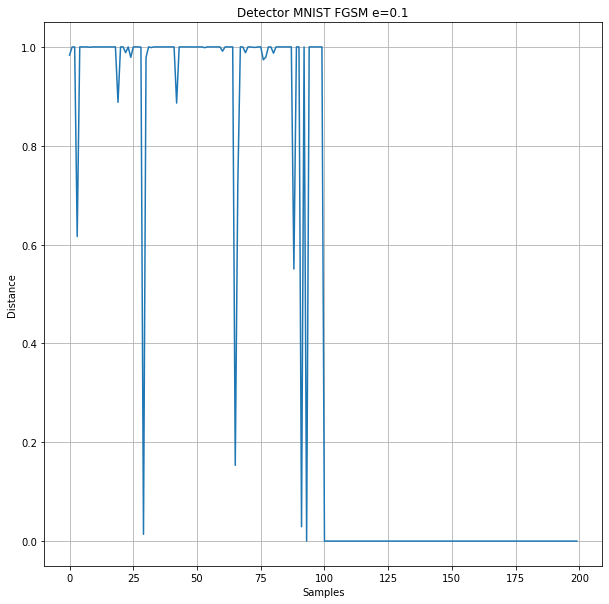

In [112]:
plt.figure(figsize=(10,10))
plt.plot(differences)
plt.grid()
plt.title("Detector MNIST FGSM e=0.1")
plt.xlabel("Samples")
plt.ylabel("Distance")

0.980314314365387
5.841255187988281e-06
0.4306701863512098
##########
0.13496851921081543
1.7070538212657653e-16
0.003206863545204364
Distance t legitimate mean: 0.003206863545204364
Distance t min-max: 0.06748718023300171
Distance t conservative mean: 0.035347021889103034
Score legitimate mean: 116
Score min-max: 104
Score conservative mean: 104
##########
Max Score: 116
Min Score: 104
Mean Score: 108.0
##########
Evaluated legitimate mean calculation as best threshold for t
True T Distance:  104
True T Adaptive:  104
True T Legitimate Mean:  116
Detection Ratio True T Distance:  162.61194029850748
Detection Ratio False T Distance:  22.388059701492537
Detection Ratio True T Adaptive:  162.61194029850748
Detection Ratio False T Adaptive:  22.388059701492537
Detection Ratio True T Mean:  177.56716417910448
Detection Ratio False T Mean:  13.432835820895523


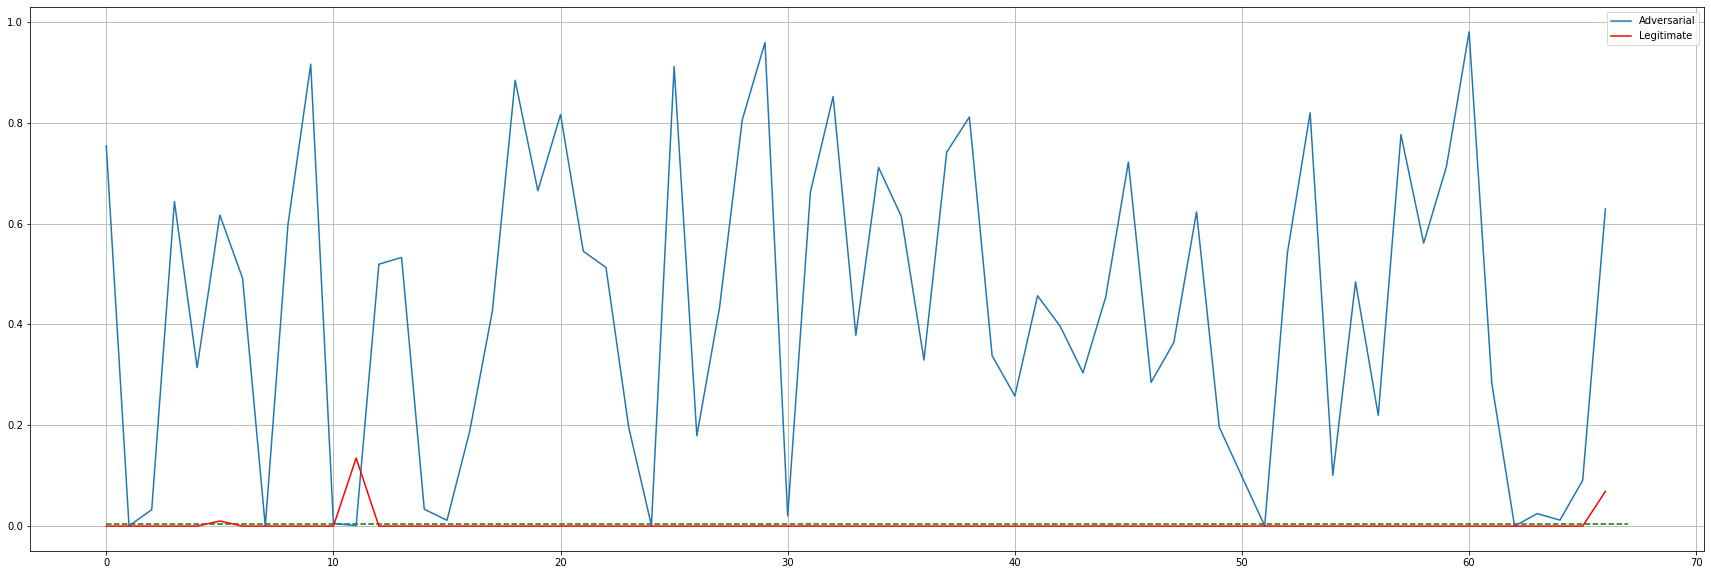

0.003206863545204364
Legitimate Samples  67
Adversarial Samples  67
True Negatives  64
False Positives  3
True Positives  61
False Negatives 6
##########
Detection Ratio TP:  91.044776119403
Detection Ratio FN:  8.955223880597016
Detection Ratio TN:  95.5223880597015
Detection Ratio FP:  4.477611940298508


In [121]:
t_value=calculate_threshold_adversarial(differences,adversarial_map,correction_t=1.0,print_output=True)

In [122]:
differences=evaluation_paper(data_test,label_test,network,t_value,evaluate=True,datatype="MNIST")

True Positives: 63
False Positives: 1
True Negatives: 66
False Negatives: 4
Accuracy: 0.9626865671641791


# Test site

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

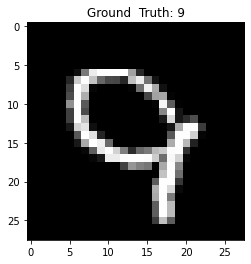

In [125]:
plt.imshow(f_d[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot


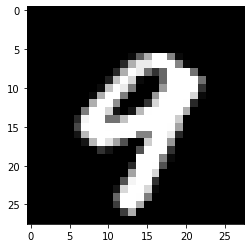

In [55]:
plt.imshow(ndimage.median_filter(f_d[0][0], size=2), cmap='gray', interpolation='none')

2


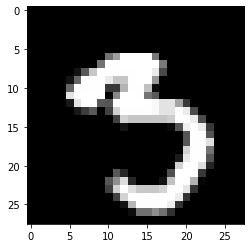

In [167]:
plt.imshow(median_smoothing(f_d[0][0]), cmap='gray', interpolation='none')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

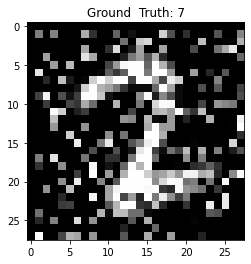

In [258]:
plt.imshow(pertubated_image[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

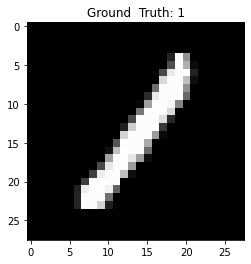

In [78]:
plt.imshow(x_d[5][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

In [163]:
median_smoothed = median_smoothing(f_d)
scaled_data = bit_reduction(f_d)
pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor

In [189]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)

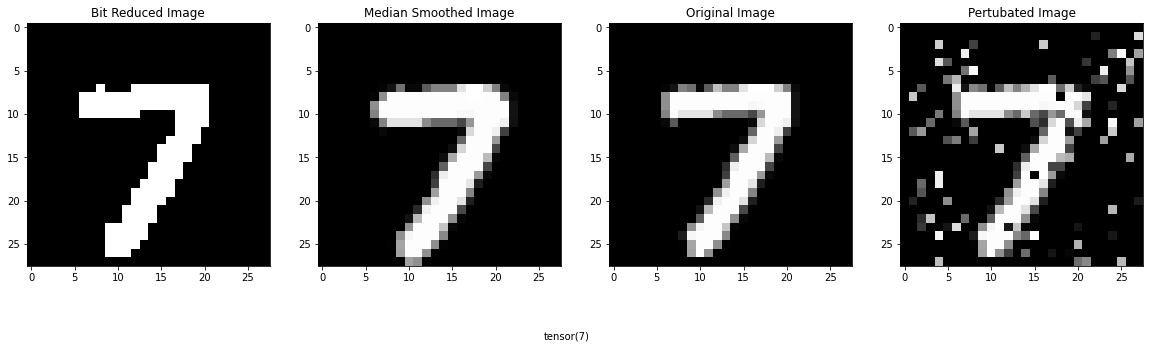

In [164]:
batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()

# Tst perturbated example

Model predicted: tensor([2])
Model predicted median smoothed: tensor([2])
Model predicted scaled: tensor([2])
##################################################################
Model predicted tensor value: 19.3311767578125
Model predicted median smoothed tensor value: 19.64731216430664
Model predicted scaled tensor value: 19.95734405517578
##################################################################
Model real: 2
Sum pixel: 784
Pertubated pixel: 95
Percent preturbated: 0.1211734693877551


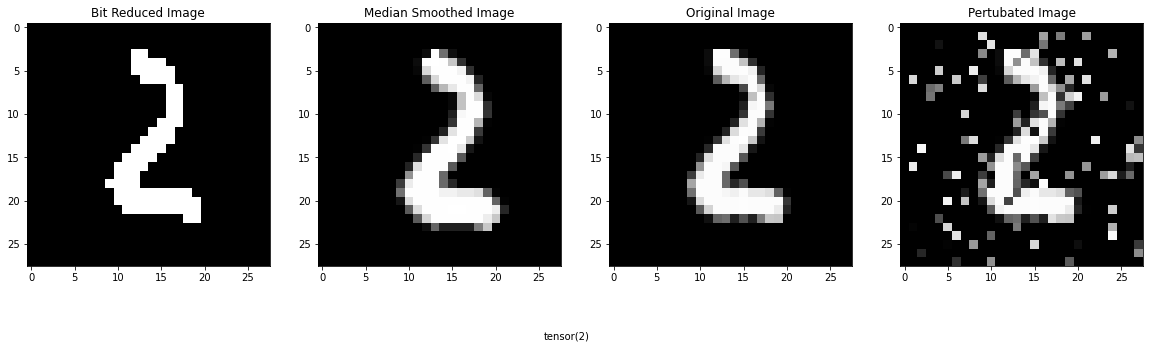

In [462]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
#networks= (network,network2,network3)

pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor
image = f_d
fake_tst = test_fake(image,network)

median_smoothed = median_smoothing(image)
scaled_data = bit_reduction(image)


fake_tst_median = test_fake(median_smoothed,network)
fake_tst_scaled = test_fake(scaled_data,network)


p_percent,p_size,p_pertubated=count_perturbated_pixel(x_d,pertubated_image)
print("Model predicted: {}".format(fake_tst.data.max(1, keepdim=True)[1][0]))
print("Model predicted median smoothed: {}".format(fake_tst_median.data.max(1, keepdim=True)[1][0]))
print("Model predicted scaled: {}".format(fake_tst_scaled.data.max(1, keepdim=True)[1][0]))

print("##################################################################")
print("Model predicted tensor value: {}".format(fake_tst.data.max(1)[0][0]))
print("Model predicted median smoothed tensor value: {}".format(fake_tst_median.data.max(1)[0][0]))
print("Model predicted scaled tensor value: {}".format(fake_tst_scaled.data.max(1)[0][0]))

print("##################################################################")
print("Model real: {}".format(e_d[0]))
print("Sum pixel: {}".format(p_size))
print("Pertubated pixel: {}".format(p_pertubated))
print("Percent preturbated: {}".format(p_percent))

####

batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()


In [32]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\Models\upgraded_net_hook.py"

In [31]:
%run "c:\GIT\Programme\code\Master\Koch\Robustness of Generative Adversial Networks\src\functions\f2d.py"

upgraded_net_hook.nn

Train:


AttributeError: module 'upgraded_net_hook' has no attribute 'ResNet20'